In [198]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Master/Randomization and Probabilistic Techniques/STS Covid 19'

/content/drive/MyDrive/Master/Randomization and Probabilistic Techniques/STS Covid 19


In [161]:
#@title Import
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

from datetime import datetime

# Plotting setup
Helper methods for plotting time series and forecasts.

In [162]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [163]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [164]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [165]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

# Review data

In [166]:
df = pd.read_csv('/content/Network Analytics.csv')

In [167]:
df['Timestamp']=pd.to_datetime(df['Timestamp'])

In [168]:
df.shape

(25631, 2)

In [169]:
df.head(10)

,Timestamp,OutboundUtilzation (%)
0,2017-10-10 07:01:00,96.2442
1,2017-10-10 07:21:00,99.1131
2,2017-10-10 07:26:00,97.2892
3,2017-10-10 07:31:00,98.0286
4,2017-10-10 07:36:00,99.5263
5,2017-10-10 07:41:00,98.8014
6,2017-10-10 07:46:00,87.9636
7,2017-10-10 07:51:00,72.2780
8,2017-10-10 07:56:00,64.3286
9,2017-10-10 08:01:00,89.9914


In [170]:
df = df.set_index('Timestamp')

In [171]:
df.rename(columns={'OutboundUtilzation (%)':'traffic_out'},inplace=True)  

In [172]:
df.index

DatetimeIndex(['2017-10-10 07:01:00', '2017-10-10 07:21:00',
               '2017-10-10 07:26:00', '2017-10-10 07:31:00',
               '2017-10-10 07:36:00', '2017-10-10 07:41:00',
               '2017-10-10 07:46:00', '2017-10-10 07:51:00',
               '2017-10-10 07:56:00', '2017-10-10 08:01:00',
               ...
               '2018-01-08 12:22:00', '2018-01-08 12:27:00',
               '2018-01-08 12:32:00', '2018-01-08 12:37:00',
               '2018-01-08 12:42:00', '2018-01-08 12:47:00',
               '2018-01-08 12:52:00', '2018-01-08 12:57:00',
               '2018-01-08 13:02:00', '2018-01-08 13:07:00'],
              dtype='datetime64[ns]', name='Timestamp', length=25631, freq=None)

In [173]:
df.head()

,traffic_out
Timestamp,
2017-10-10 07:01:00,96.2442
2017-10-10 07:21:00,99.1131
2017-10-10 07:26:00,97.2892
2017-10-10 07:31:00,98.0286
2017-10-10 07:36:00,99.5263


In [174]:
df.tail()

,traffic_out
Timestamp,
2018-01-08 12:47:00,4.20296
2018-01-08 12:52:00,5.22635
2018-01-08 12:57:00,5.38923
2018-01-08 13:02:00,35.50460
2018-01-08 13:07:00,58.87990


In [175]:
# shape of the dataframe
df.shape

(25631, 1)

In [176]:
# concise summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25631 entries, 2017-10-10 07:01:00 to 2018-01-08 13:07:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   traffic_out  25631 non-null  float64
dtypes: float64(1)
memory usage: 400.5 KB


In [177]:
# checking for null values
df.isnull().sum()

traffic_out    0
dtype: int64

In [178]:
# descriptive statistics of data
df.describe()

,traffic_out
count,25631.000000
mean,60.372335
std,22.517275
min,0.000048
25%,44.873850
50%,62.100200
75%,77.702150
max,99.995500


Text(0.5, 1.0, 'Network Analytics')

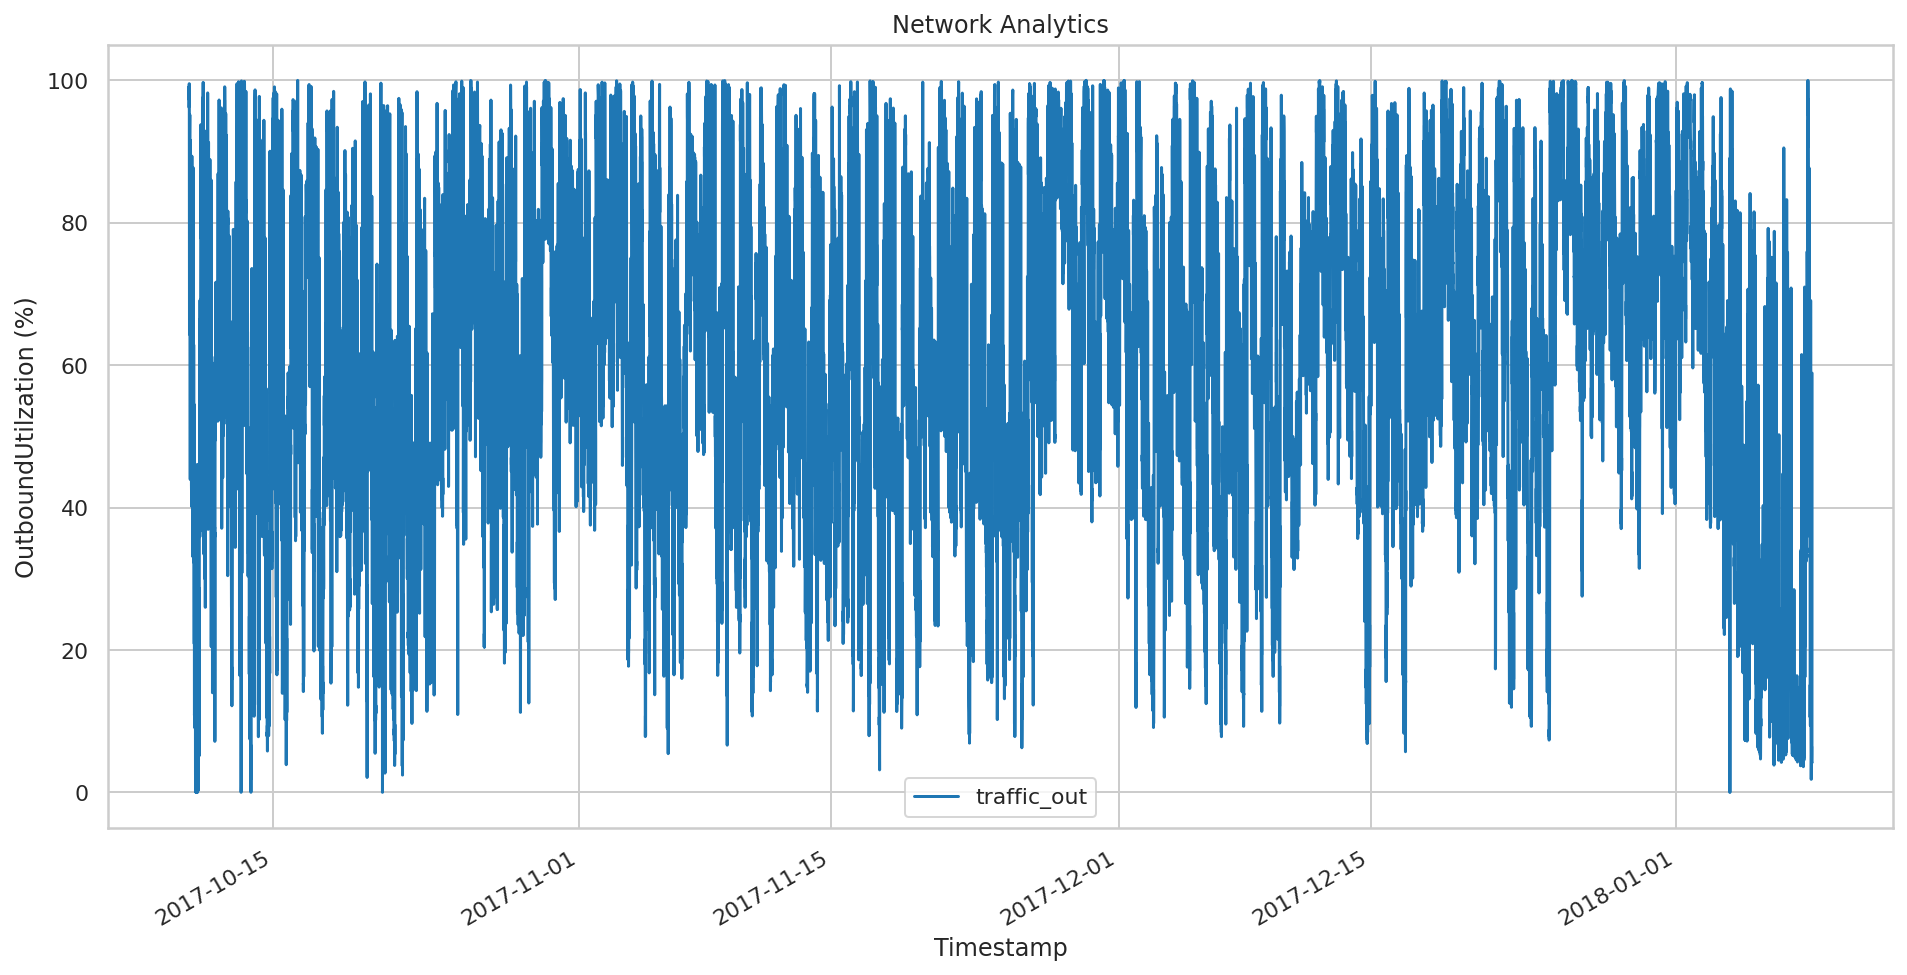

In [179]:
df.plot(figsize=(16,8))
plt.ylabel('OutboundUtilzation (%)')
plt.title('Network Analytics')

As data is too noisy, because it is sampled every 5 minutes aprox, we will resample it to 1H periods, using the mean value for each such period

In [180]:
traffic_1H = df.resample('1H').mean()

In [181]:
traffic_1H

,traffic_out
Timestamp,
2017-10-10 07:00:00,90.397000
2017-10-10 08:00:00,74.493000
2017-10-10 09:00:00,68.930125
2017-10-10 10:00:00,52.874208
2017-10-10 11:00:00,58.498275
...,...
2018-01-08 09:00:00,62.735358
2018-01-08 10:00:00,25.123941
2018-01-08 11:00:00,20.139626


Text(0.5, 1.0, 'Network Analytics')

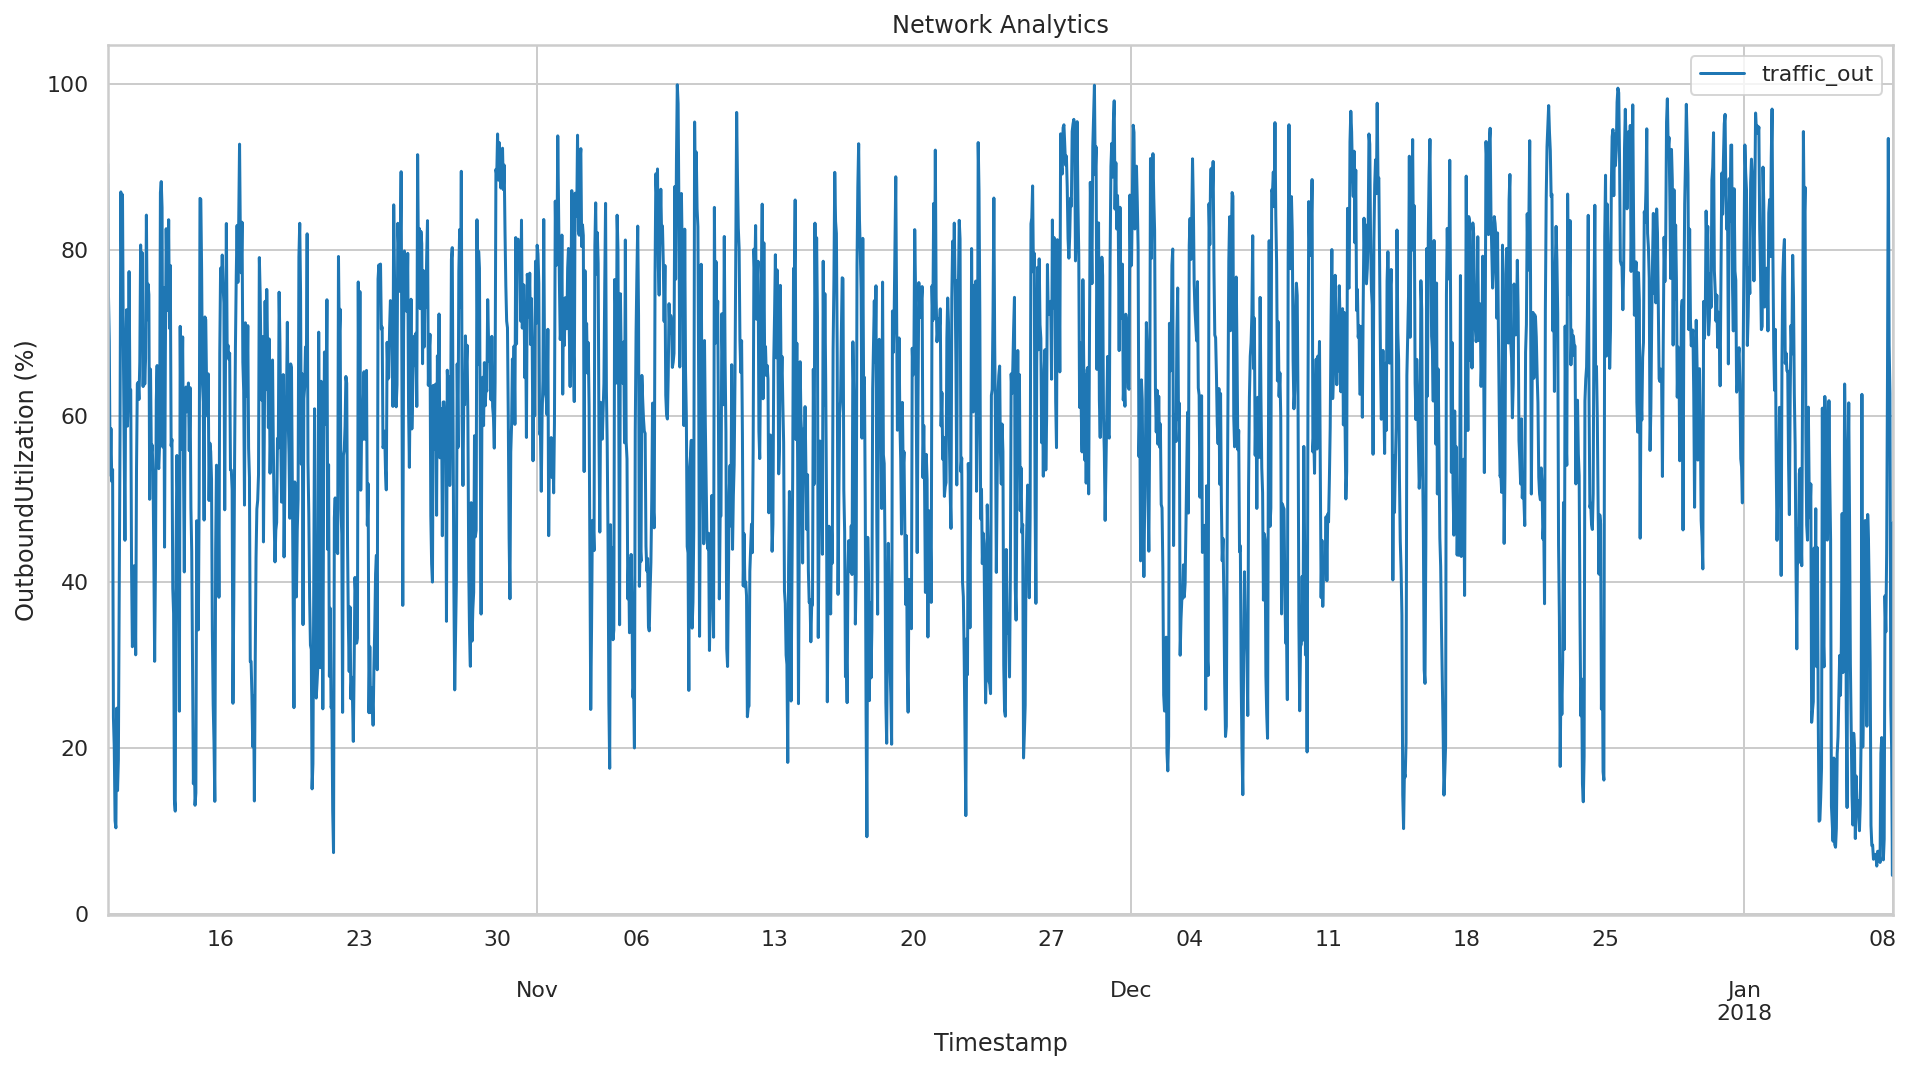

In [182]:
traffic_1H.plot(figsize=(16,8))
plt.ylabel('OutboundUtilzation (%)')
plt.title('Network Analytics')

# STS model

In [183]:
confirmed_loc = mdates.WeekdayLocator(byweekday=mdates.MO)
confirmed_fmt = mdates.DateFormatter('%a %b %d')

num_forecast_steps = 24 * 7 * 2 # Two weeks.
confirmed_training_data = traffic_1H[:-num_forecast_steps]

## Model and fitting

Our model combines a hour-of-day and day-of-week seasonality, and an autoregressive process to handle bounded-variance residuals.

In [184]:
def build_model(observed_time_series):
  #trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  hour_of_day_effect = sts.Seasonal(
      num_seasons=24,
      observed_time_series=observed_time_series,
      name='hour_of_day_effect')
  day_of_week_effect = sts.Seasonal(
      num_seasons=7, num_steps_per_season=24,
      observed_time_series=observed_time_series,
      name='day_of_week_effect')
  
  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
  model = sts.Sum([#trend,
                   hour_of_day_effect,
                   day_of_week_effect,
                   
                   autoregressive],
                   observed_time_series=observed_time_series)
  return model

In [185]:
traffic_1H.index

DatetimeIndex(['2017-10-10 07:00:00', '2017-10-10 08:00:00',
               '2017-10-10 09:00:00', '2017-10-10 10:00:00',
               '2017-10-10 11:00:00', '2017-10-10 12:00:00',
               '2017-10-10 13:00:00', '2017-10-10 14:00:00',
               '2017-10-10 15:00:00', '2017-10-10 16:00:00',
               ...
               '2018-01-08 04:00:00', '2018-01-08 05:00:00',
               '2018-01-08 06:00:00', '2018-01-08 07:00:00',
               '2018-01-08 08:00:00', '2018-01-08 09:00:00',
               '2018-01-08 10:00:00', '2018-01-08 11:00:00',
               '2018-01-08 12:00:00', '2018-01-08 13:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=2167, freq='H')

In [186]:
confirmed_model = build_model(confirmed_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=confirmed_model)

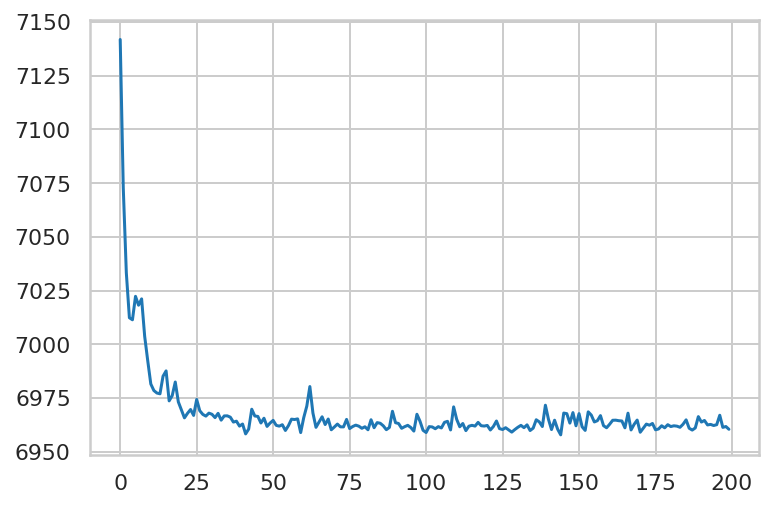

In [187]:
#@title Minimize the variational loss.
#Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=confirmed_model.joint_log_prob(
        observed_time_series=confirmed_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)
plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_confirmed_ = variational_posteriors.sample(50)

In [188]:
print("Inferred parameters:")
for param in confirmed_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_confirmed_[param.name], axis=0),
                              np.std(q_samples_confirmed_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 3.805028983230751 +- 0.24923046312105165
hour_of_day_effect/_drift_scale: 1.085433563040095 +- 0.11587905078298927
day_of_week_effect/_drift_scale: 0.28152602395659393 +- 0.5900021279542675
autoregressive/_coefficients: [0.78485115] +- [0.01590429]
autoregressive/_level_scale: 8.300665543708877 +- 0.1331934543906051


## Forecasting and criticism

In [189]:
confirmed_forecast_dist = tfp.sts.forecast(
    model=confirmed_model,
    observed_time_series=confirmed_training_data,
    parameter_samples=q_samples_confirmed_,
    num_steps_forecast=num_forecast_steps)

In [190]:
num_samples=10

(
    confirmed_forecast_mean,
    confirmed_forecast_scale,
    confirmed_forecast_samples
) = (
    confirmed_forecast_dist.mean().numpy()[..., 0],
    confirmed_forecast_dist.stddev().numpy()[..., 0],
    confirmed_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

In [191]:
a = np.arange('2017-10-10 07:00:00', '2018-01-08 14:00:00', dtype='datetime64[h]')
print(a.shape)

b = traffic_1H['traffic_out']
print(b.shape)

(2167,)
(2167,)


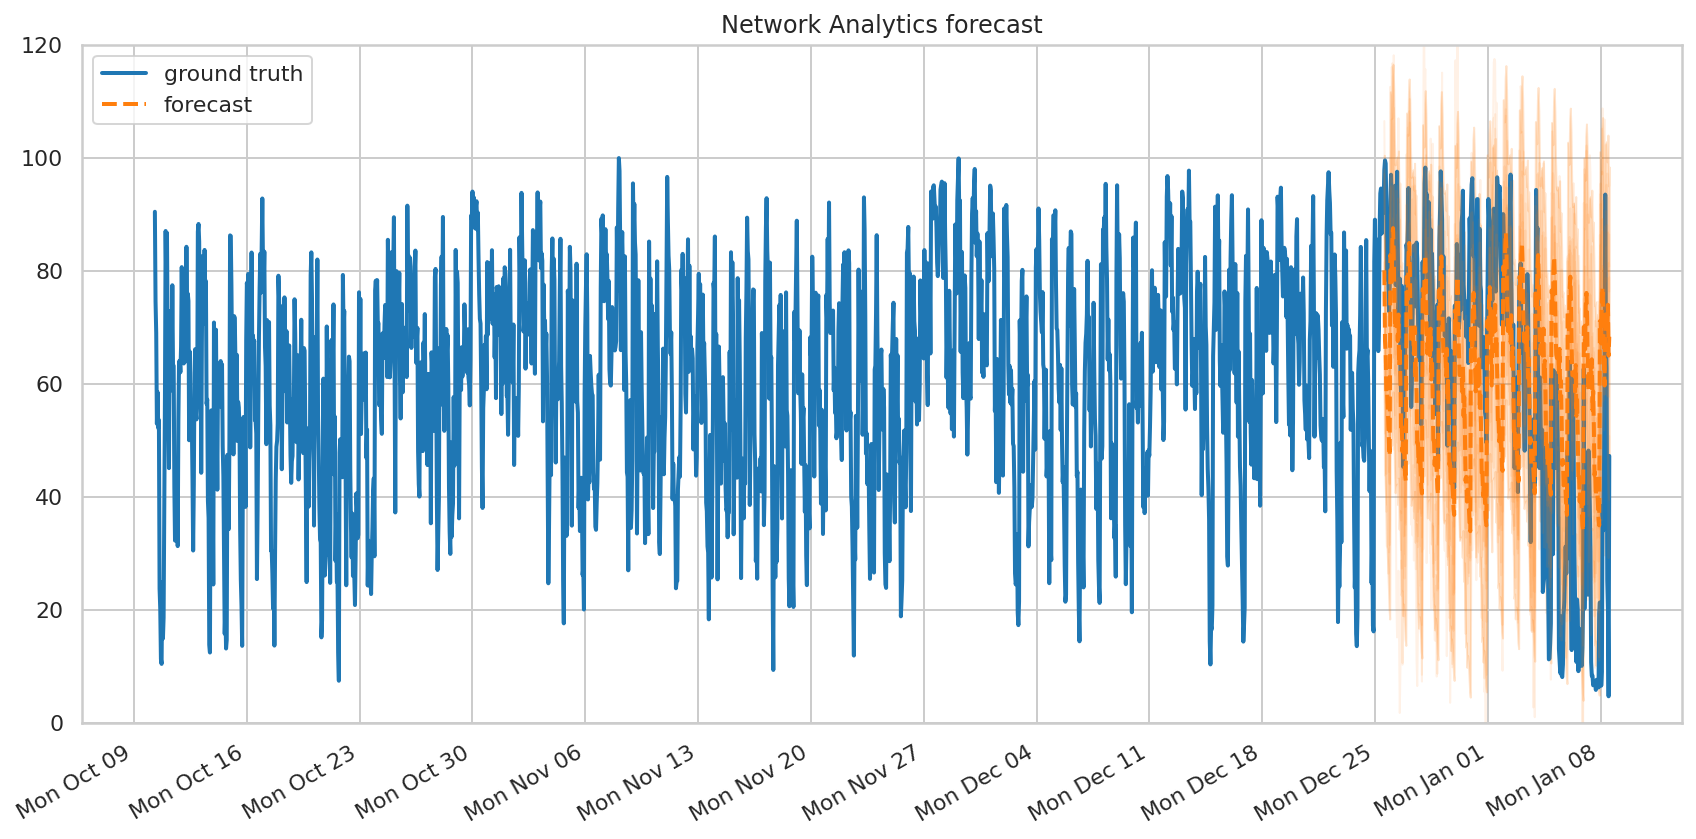

In [192]:
fig, ax = plot_forecast(a, b,
                        confirmed_forecast_mean,
                        confirmed_forecast_scale,
                        confirmed_forecast_samples,
                        title="Network Analytics forecast",
                        x_locator=confirmed_loc, x_formatter=confirmed_fmt)
ax.set_ylim([0, 120])
fig.tight_layout()

### Visualize the decomposition

In [193]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    confirmed_model,
    observed_time_series=confirmed_training_data,
    parameter_samples=q_samples_confirmed_)

forecast_component_dists = sts.decompose_forecast_by_component(
    confirmed_model,
    forecast_dist=confirmed_forecast_dist,
    parameter_samples=q_samples_confirmed_)

In [194]:
confirmed_component_means_, confirmed_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    confirmed_forecast_component_means_,
    confirmed_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

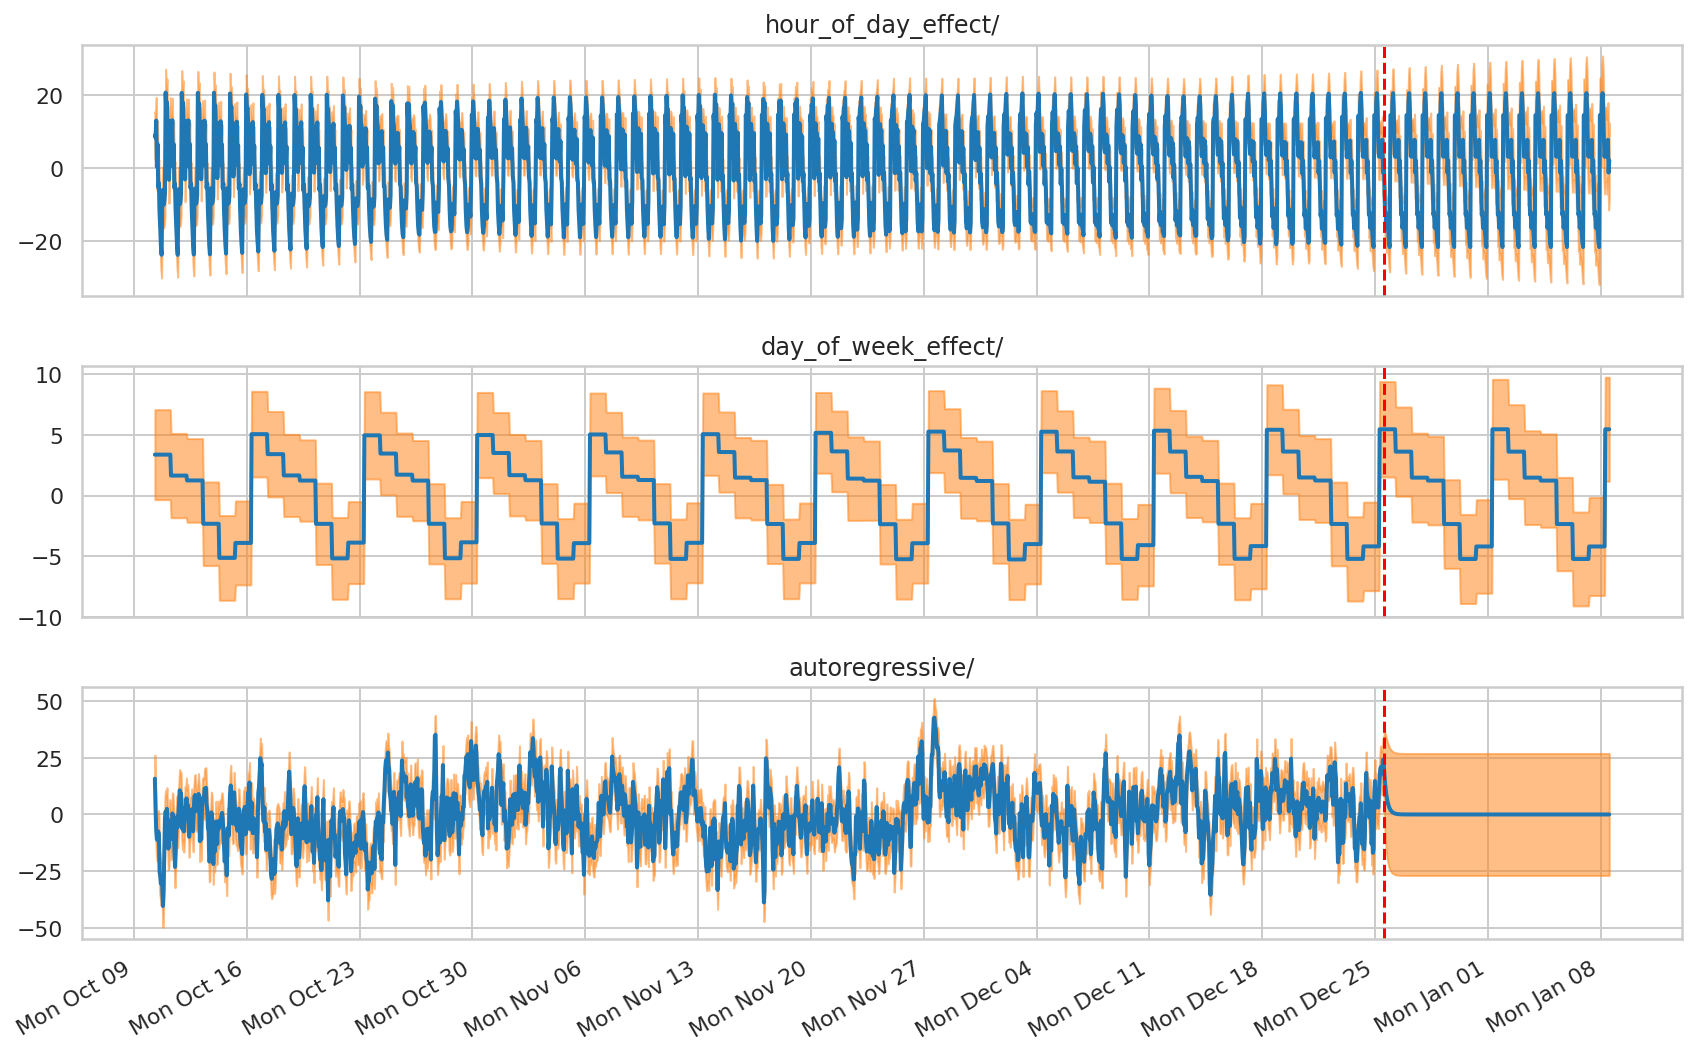

In [195]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in confirmed_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      confirmed_component_means_[k],
      confirmed_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      confirmed_component_stddevs_[k],
      confirmed_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
  traffic_1H.index,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=confirmed_loc, x_formatter=confirmed_fmt)
for ax in axes.values():
  ax.axvline(traffic_1H.index[-num_forecast_steps], linestyle="--", color='red')

### One-step predictive distributions

If we wanted to detect anomalies in the observed series, we might also be interested in the one-step predictive distributions: the forecast for each timestep, given only the timesteps up to that point. tfp.sts.one_step_predictive computes all of the one-step predictive distributions in a single pass:

In [196]:
confirmed_one_step_dist = sts.one_step_predictive(
    confirmed_model,
    observed_time_series=traffic_1H['traffic_out'],
    parameter_samples=q_samples_confirmed_)

confirmed_one_step_mean, confirmed_one_step_scale = (
    confirmed_one_step_dist.mean().numpy(), confirmed_one_step_dist.stddev().numpy())

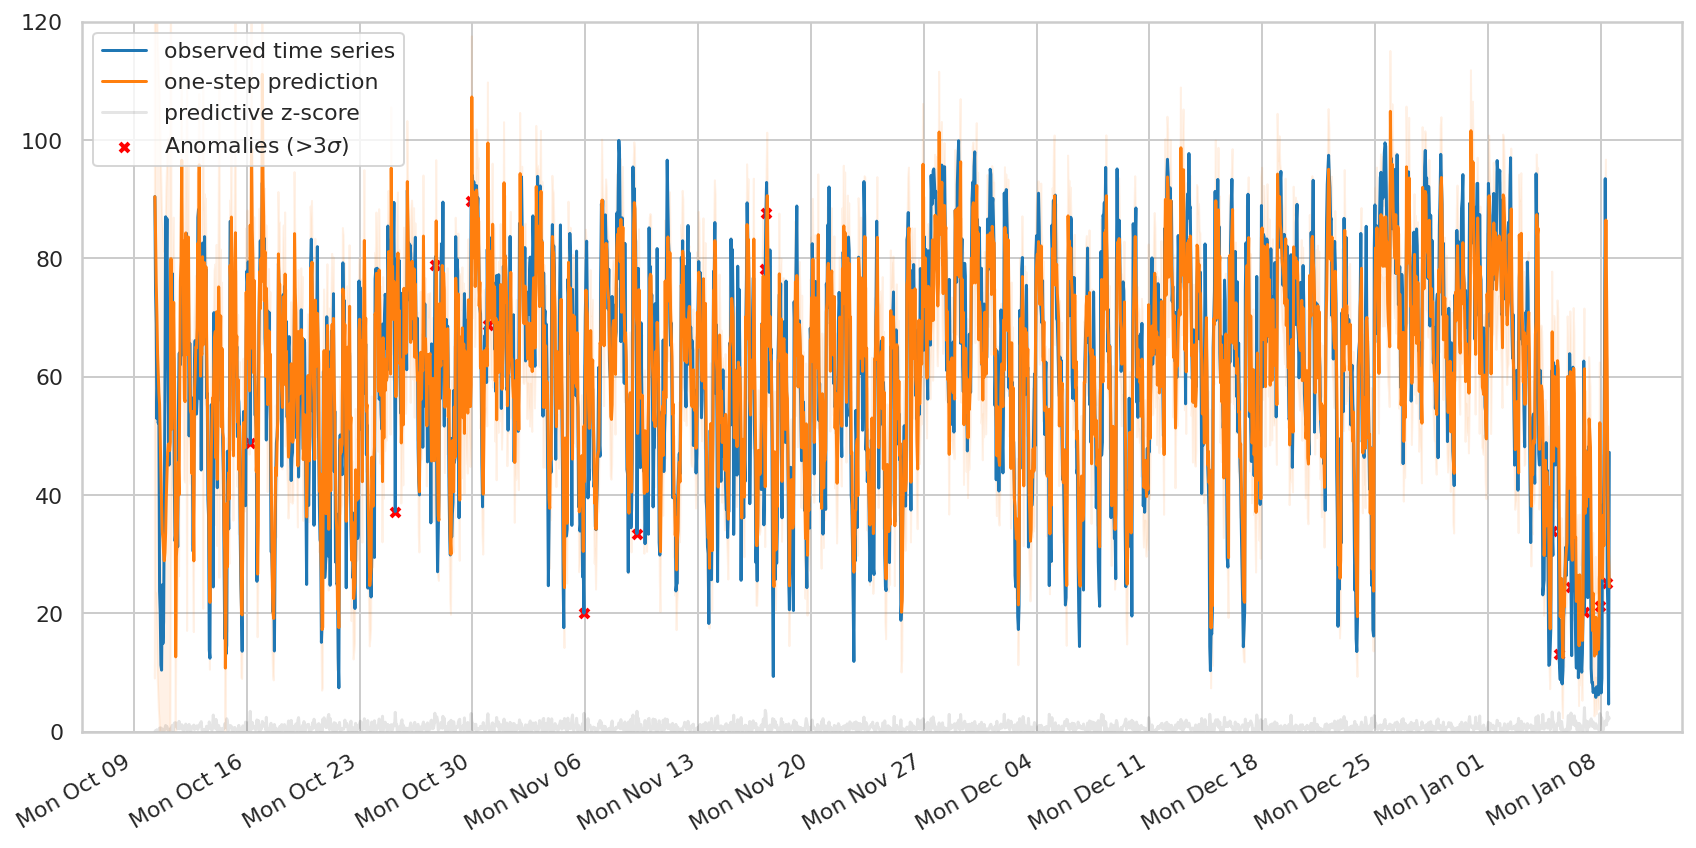

In [197]:
fig, ax = plot_one_step_predictive(
    traffic_1H.index, traffic_1H['traffic_out'],
    confirmed_one_step_mean, confirmed_one_step_scale,
    x_locator=confirmed_loc, x_formatter=confirmed_fmt)
ax.set_ylim(0, 120)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((traffic_1H['traffic_out'] - confirmed_one_step_mean) /
                 confirmed_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(traffic_1H.index[anomalies],
           traffic_1H['traffic_out'][anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3$\sigma$)")
ax.plot(traffic_1H.index, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()